In [1]:
from PIL import Image

import numpy as np
import pandas as pd 

#Visualization
import matplotlib.pyplot as plt

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#System
import os

import warnings
warnings.filterwarnings('ignore')

# Dataset:
+ 40 folders equivalent to 40 distinct people
+ Each folder includes 10 diffents images of one person
+ Image size is 112 x 92 pixel

# Task 1
+ Read image
+ Implement PCA
+ Visual image, eigenface, average face

In [2]:
GALLERY = "Data\\Dataset 1 (ATT)\\"
## Storing Images and corresponding labels
images = list()
labels = list()
for folder in os.listdir(GALLERY):
    for img in os.listdir(GALLERY + "/" + folder):
        img = Image.open(GALLERY + "/" + folder + "/" + img)
        images.append(np.array(img))

        # folder syntax: 's' + k ,with k is id of person
        labels.append(int(folder.split("s")[1]))

In [3]:
def beautify(ax):
    ax.spines[['top','bottom','left','right']].set_visible(False)
    ax.tick_params(left=False, bottom = False, top=False, right =False)
    ax.set_yticklabels('')
    ax.set_xticklabels('')

def show_all_face_of(id):
    for i in range(len(labels)):
        if labels[i] == id:
            start = i
            break
    person = images[start:start+10]
    f, axs = plt.subplots(1, 10, figsize=(10, 10))
    axs = axs.flatten()
    for i, (img, ax) in enumerate(zip(person, axs)):
        ax.imshow(img, cmap="gray")
        beautify(ax)
    plt.show()

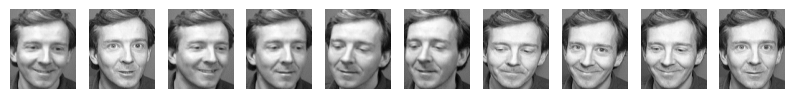

In [4]:
show_all_face_of(3)

In [5]:
# Prepare X, y for model
shape = images[0].shape
X = np.resize(images,(len(images), shape[0]*shape[1]))
y = np.array(labels).reshape(-1,1)
y.shape

(400, 1)

In [6]:
# Split data ( stratify - y assure that train/test ratio (7/3) is true for each person)
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
print("X_train shape:",X_train.shape)
print("y_train shape:",y_train.shape)

X_train shape: (280, 10304)
y_train shape: (280, 1)


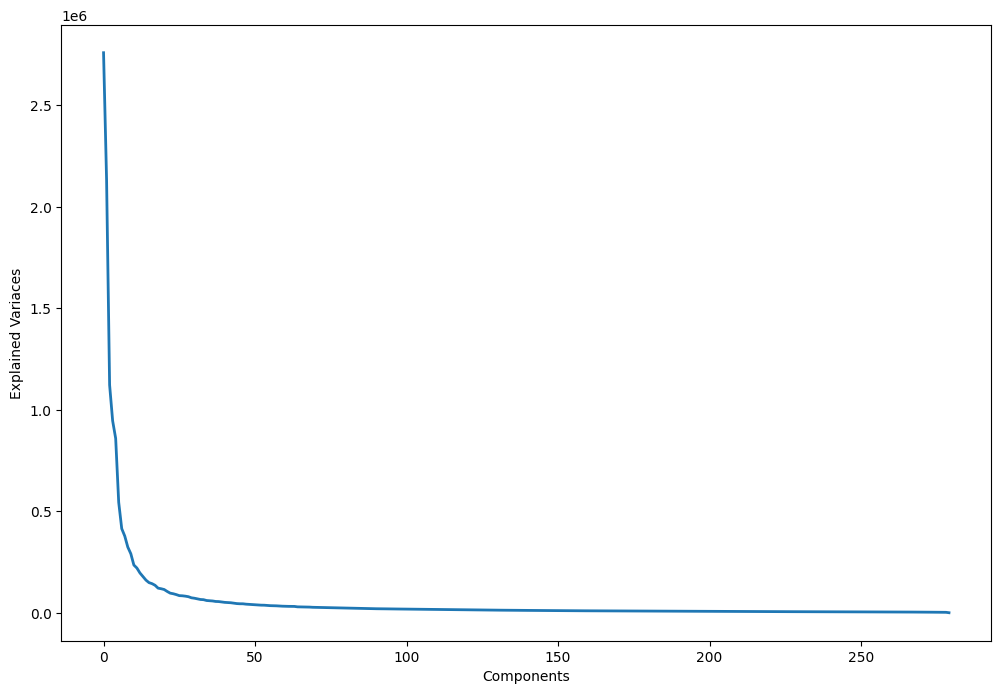

In [7]:
# Find the best n_components
pca=PCA()
pca.fit(X_train)  
plt.figure(1, figsize=(12,8))
plt.plot(pca.explained_variance_, linewidth=2) 
plt.xlabel('Components')
plt.ylabel('Explained Variaces')
plt.show()

Từ hình trên sẽ def cái hàm để chọn n_components tối nhất, ở đây đang dùng 50. Emplement lại PCA với parameter

In [8]:
n_components=60
pca=PCA(n_components=n_components, whiten=True, svd_solver='auto') # xem para svd_solver là gì
pca.fit(X_train)

PCA(n_components=60, whiten=True)

Text(0.5, 1.0, 'Average Face')

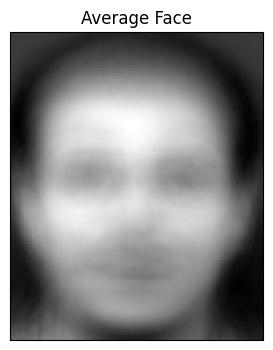

In [9]:
# viusalize Mean của toàn bộ tập train
fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.imshow(pca.mean_.reshape((shape[0],shape[1])), cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Average Face')

Text(0.5, 0.98, 'All Eigen Faces')

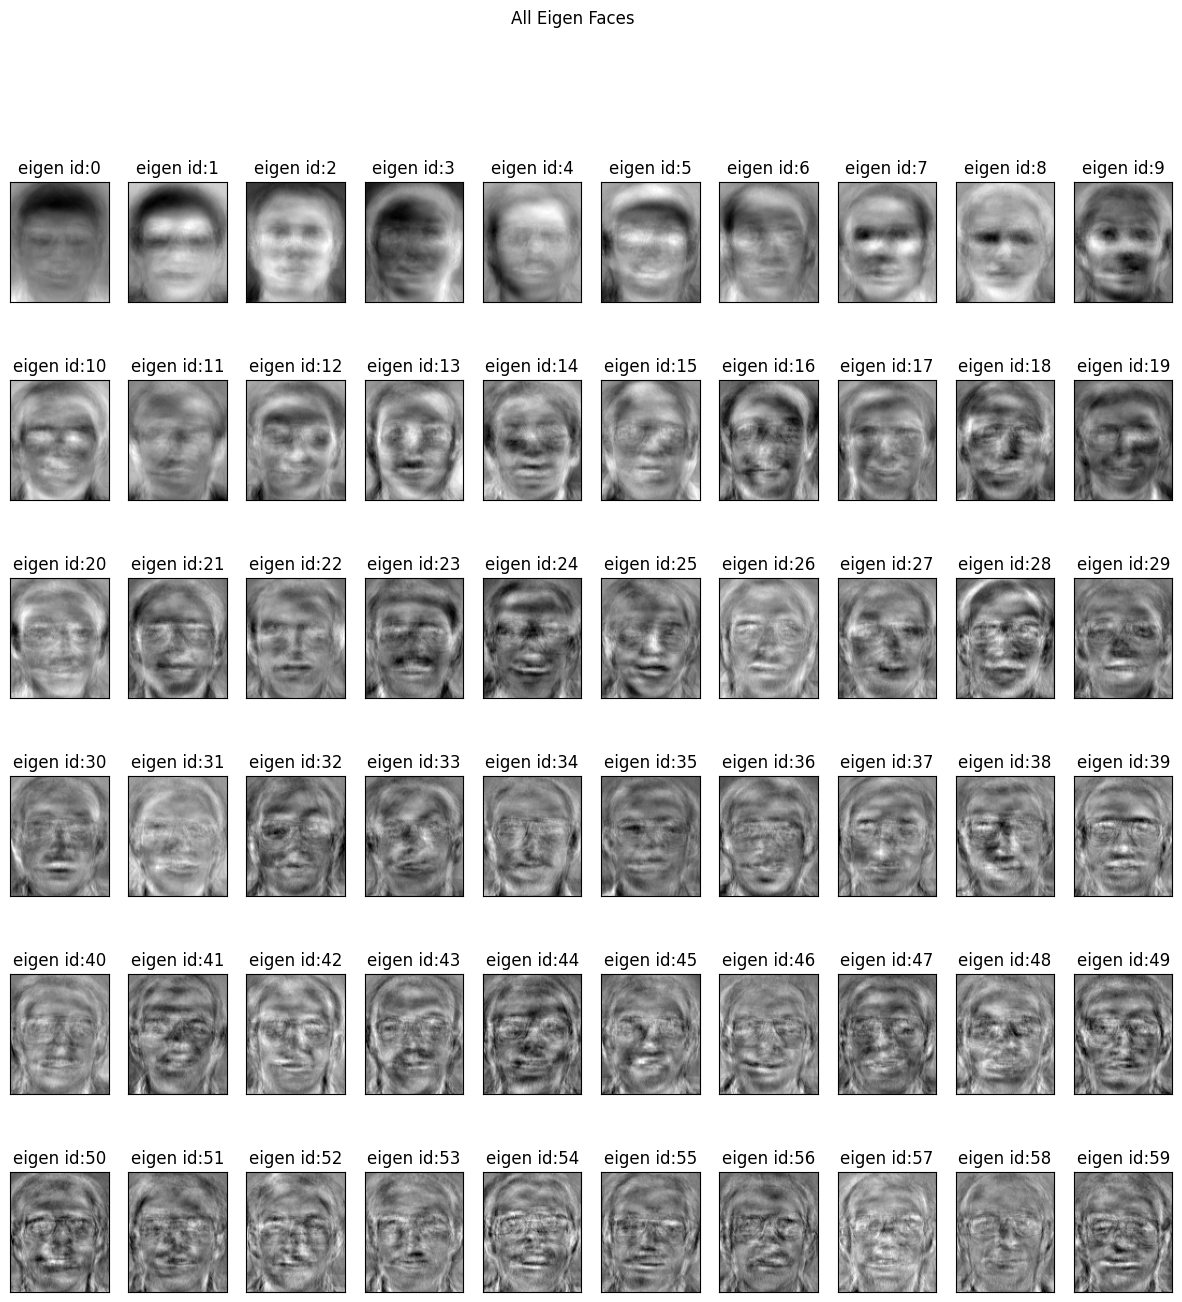

In [10]:
# Visualize eigenface
eigenfaces = pca.components_.reshape(n_components,shape[0],shape[1]) #90x112x92

cols=10
rows=int(n_components/cols)
fig, axarr=plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))
axarr=axarr.flatten()
for i in range(n_components):
    axarr[i].imshow(eigenfaces[i],cmap="gray")
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title("eigen id:{}".format(i))
plt.suptitle("All Eigen Faces".format(10*"=", 10*"="))

In [11]:
# Tranform
X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)

# Task 2
+ Try Incremental PCA, Kernel PCA, LLE
+ Implement Euclide distance for task 1, try other classification method 
+ Tunning parameter

# Cross Validation

In [12]:
models=[]
models.append(("KNN (euclide)", KNeighborsClassifier(n_neighbors=1, metric= 'euclidean')))
models.append(("KNN (manhattan)", KNeighborsClassifier(n_neighbors=1, metric='manhattan')))
models.append(("KNN (minkowski)", KNeighborsClassifier(n_neighbors=1, metric='minkowski')))
models.append(("KNN", KNeighborsClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(("LR", LogisticRegression()))
models.append(("NB", GaussianNB()))
models.append(("DT", DecisionTreeClassifier()))
models.append(("SVM", SVC()))

pca=PCA(n_components=n_components, whiten=True)
pca.fit(X)
X_pca=pca.transform(X)

In [13]:
# K-fold

for name, model in models:
    kfold=KFold(n_splits=5, shuffle=True, random_state=0)
    
    cv_scores=cross_val_score(model, X_pca, labels, cv=kfold)
    print("{} K-fold mean cross validations score: {:.2f}".format(name, cv_scores.mean()))

KNN (euclide) K-fold mean cross validations score: 0.93
KNN (manhattan) K-fold mean cross validations score: 0.93
KNN (minkowski) K-fold mean cross validations score: 0.93
KNN K-fold mean cross validations score: 0.79
LDA K-fold mean cross validations score: 0.98
LR K-fold mean cross validations score: 0.97
NB K-fold mean cross validations score: 0.87
DT K-fold mean cross validations score: 0.61
SVM K-fold mean cross validations score: 0.96


In [14]:
# Leave One Out 

for name, model in models:
    loo_cv=LeaveOneOut()
    cv_scores=cross_val_score(model, X_pca, labels, cv=loo_cv)
    print("{} LOO mean cross validations score: {:.2f}".format(name, cv_scores.mean()))

KNN (euclide) LOO mean cross validations score: 0.94
KNN (manhattan) LOO mean cross validations score: 0.94
KNN (minkowski) LOO mean cross validations score: 0.94
KNN LOO mean cross validations score: 0.86
LDA LOO mean cross validations score: 0.99
LR LOO mean cross validations score: 0.97
NB LOO mean cross validations score: 0.93
DT LOO mean cross validations score: 0.68
SVM LOO mean cross validations score: 0.97


+ Dễ thấy score LOO > K-fold
+ Ranking classifier model: LDA -> LR -> SVC -> NB -> KNN -> DT

# Tunning

In [15]:
# # Cho logistic Regression

# # Define a range of parameters for Grid Search
# param_grid = {
#     'penalty': ['l1', 'l2'],                   # Regularization penalty
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],       # Inverse of regularization strength
#     'solver': [
#         'newton-cg'
#     #     'liblinear'
#     # , 'saga'
#     ],           # Solver for optimization
#     'multi_class': ['ovr', 'multinomial'],     # Strategy for multiclass problems
#     'max_iter': [100, 200, 300],               # Maximum number of iterations
# }

# # Instantiate Logistic Regression classifier
# lr = LogisticRegression()

# # Instantiate GridSearchCV
# grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')

# # Perform Grid Search
# grid_search.fit(X_train_pca, y_train)

# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Get the best estimator
# best_lr = grid_search.best_estimator_

# # Make predictions on the test data
# y_pred = best_lr.predict(X_test_pca)

# # Print classification report
# print(metrics.classification_report(y_test, y_pred))

In [16]:
# # Cho Linear Discre Analyst

# param_grid = {
#     'solver': ['svd', 'lsqr', 'eigen'],         # LDA solver methods
#     'shrinkage': [None, 'auto', 0.1, 0.5, 0.9],  # Shrinkage parameter
#     'n_components': [None, 1, 2, 3, 4, 5],       # Number of components to keep
#     'tol': [1e-4, 1e-3, 1e-2],                   # Tolerance for eigenvalues
#     'store_covariance': [True, False],           # Whether to store the covariance matrix
#     'priors': [None, [0.1, 0.9], [0.3, 0.7], [0.5, 0.5]],  # Class priors
# }

# # Instantiate LDA classifier
# lda = LinearDiscriminantAnalysis()

# # Instantiate GridSearchCV
# grid_search = GridSearchCV(lda, param_grid, cv=5, scoring='accuracy')

# # Perform Grid Search
# grid_search.fit(X_train_pca, y_train)

# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Get the best estimator
# best_lda = grid_search.best_estimator_

# # Make predictions on the test data
# y_pred = best_lda.predict(X_test_pca)

# # Print classification report
# print(metrics.classification_report(y_test, y_pred))

In [17]:
# Cho SVM

# from sklearn.svm import SVC

# # Define a range of parameters for Grid Search
# param_grid = {
#     'C': [0.2, 2, 10],                  # Regularization parameter
#     'kernel': ['linear', 'rbf'],        # Kernel type
#     'gamma': ['scale', 'auto'],         # Kernel coefficient
#     'degree': [1, 2, 3, 4, 5],          # Degree of the polynomial kernel function
#     'shrinking': [True, False]          # Whether to use the shrinking heuristic
# }

# # Instantiate SVM classifier
# svm = SVC()

# # Instantiate GridSearchCV
# grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')

# # Perform Grid Search
# grid_search.fit(X_train_pca, y_train)

# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Get the best estimator
# best_svm = grid_search.best_estimator_

# # Make predictions on the test data
# y_pred = best_svm.predict(X_test_pca)

# # Print classification report
# print(metrics.classification_report(y_test, y_pred))

In [18]:
def evaluate(X_train, X_test, y_train, y_test, dim_red_method, method_name):

    #Transform  input
    dim_red_method.fit(X_train)
    dim_red_method.fit(X_test)
    X_train = dim_red_method.transform(X_train)
    X_test = dim_red_method.transform(X_test)

    # Euclide
    method = KNeighborsClassifier(n_neighbors=1, metric= 'euclidean')
    method.fit(X_train, y_train)
    y_pred_euc = method.predict(X_test)

    # LDA
    lda = LinearDiscriminantAnalysis(n_components= None, priors= None, shrinkage= None, solver= 'svd', store_covariance= True, tol= 0.0001)
    lda.fit(X_train, y_train)
    y_pred_lda = lda.predict(X_test)

    # Logistic Regression
    lr = LogisticRegression(C=1, max_iter= 100, multi_class= 'ovr', penalty= 'l2', solver= 'newton-cg')
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)


    # Combined 
    pipeline = Pipeline([
        ('lda',  lda),\
        ('logreg', lr),\
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # SVM
    svc = SVC(C = 0.2, degree = 1, gamma = 'scale', kernel= 'linear', shrinking= True)
    svc.fit(X_train, y_train)
    y_pred_svc = svc.predict(X_test)

    # Validation on test set
    acc = {
        'Euclide': metrics.accuracy_score(y_test, y_pred_euc),\
        'LDA': metrics.accuracy_score(y_test, y_pred_lda),\
        'LR' : metrics.accuracy_score(y_test, y_pred_lr),\
        'LDA + LR' : metrics.accuracy_score(y_test, y_pred),\
        'SVC' : metrics.accuracy_score(y_test, y_pred_svc)
    }

    return pd.DataFrame.from_dict(acc, orient='index',columns=[method_name])


In [19]:
record = pd.DataFrame(index=['Euclide','LDA','LR','LDA + LR','SVC'])

for i in range(50,65):
    model = PCA(n_components=i, whiten=True, svd_solver='auto')                      
    ans = evaluate(X_train, X_test, y_train, y_test, model, str(model))
    record = pd.concat([record,ans],axis=1)
record.T

,Euclide,LDA,LR,LDA + LR,SVC
"PCA(n_components=50, whiten=True)",0.950000,0.991667,0.966667,0.983333,0.975000
"PCA(n_components=51, whiten=True)",0.950000,0.991667,0.983333,0.983333,0.983333
"PCA(n_components=52, whiten=True)",0.950000,0.991667,0.983333,0.983333,0.983333
"PCA(n_components=53, whiten=True)",0.958333,0.983333,0.966667,0.975000,0.975000
"PCA(n_components=54, whiten=True)",0.950000,0.983333,0.958333,0.975000,0.975000
"PCA(n_components=55, whiten=True)",0.950000,0.983333,0.983333,0.983333,0.983333
"PCA(n_components=56, whiten=True)",0.950000,0.983333,0.966667,0.983333,0.966667
"PCA(n_components=57, whiten=True)",0.966667,0.983333,0.975000,0.983333,0.975000
"PCA(n_components=58, whiten=True)",0.941667,0.983333,0.975000,0.983333,0.983333
"PCA(n_components=59, whiten=True)",0.950000,0.991667,0.958333,0.991667,0.975000


In [20]:
from sklearn.decomposition import IncrementalPCA

record = pd.DataFrame(index=['Euclide','LDA','LR','LDA + LR','SVC'])

for i in range(50,66):
    model = IncrementalPCA(n_components=i)                    
    ans = evaluate(X_train, X_test, y_train, y_test, model, str(model))
    record = pd.concat([record,ans],axis=1)
record.T

,Euclide,LDA,LR,LDA + LR,SVC
IncrementalPCA(n_components=50),0.983333,0.991667,0.975000,0.975000,0.983333
IncrementalPCA(n_components=51),0.983333,0.991667,0.991667,0.983333,0.983333
IncrementalPCA(n_components=52),0.983333,0.991667,0.991667,0.983333,0.983333
IncrementalPCA(n_components=53),0.983333,0.991667,0.991667,0.983333,0.983333
IncrementalPCA(n_components=54),0.983333,1.000000,0.983333,0.983333,0.983333
IncrementalPCA(n_components=55),0.983333,0.991667,0.983333,0.983333,0.983333
IncrementalPCA(n_components=56),0.983333,0.983333,0.991667,0.983333,0.983333
IncrementalPCA(n_components=57),0.983333,0.983333,0.991667,0.991667,0.983333
IncrementalPCA(n_components=58),0.983333,0.991667,0.983333,0.991667,0.983333
IncrementalPCA(n_components=59),0.983333,0.983333,0.983333,0.991667,0.983333


In [21]:
from sklearn.decomposition import KernelPCA

record = pd.DataFrame(index=['Euclide','LDA','LR','LDA + LR','SVC'])

for i in range(50,66):
    model = KernelPCA(n_components=i, kernel='poly', degree= 4)                  
    ans = evaluate(X_train, X_test, y_train, y_test, model, str(model))
    record = pd.concat([record,ans],axis=1)
record.T

,Euclide,LDA,LR,LDA + LR,SVC
"KernelPCA(degree=4, kernel='poly', n_components=50)",0.966667,0.975000,0.950000,0.975000,0.966667
"KernelPCA(degree=4, kernel='poly', n_components=51)",0.966667,0.975000,0.958333,0.958333,0.966667
"KernelPCA(degree=4, kernel='poly', n_components=52)",0.966667,0.975000,0.958333,0.958333,0.966667
"KernelPCA(degree=4, kernel='poly', n_components=53)",0.966667,0.983333,0.966667,0.958333,0.966667
"KernelPCA(degree=4, kernel='poly', n_components=54)",0.966667,0.983333,0.958333,0.958333,0.966667
"KernelPCA(degree=4, kernel='poly', n_components=55)",0.966667,0.983333,0.958333,0.966667,0.966667
"KernelPCA(degree=4, kernel='poly', n_components=56)",0.966667,0.983333,0.966667,0.966667,0.966667
"KernelPCA(degree=4, kernel='poly', n_components=57)",0.966667,0.983333,0.958333,0.958333,0.966667
"KernelPCA(degree=4, kernel='poly', n_components=58)",0.966667,0.983333,0.958333,0.958333,0.966667
"KernelPCA(degree=4, kernel='poly', n_components=59)",0.966667,0.983333,0.966667,0.958333,0.975000


In [22]:
from sklearn.manifold import LocallyLinearEmbedding

record = pd.DataFrame(index=['Euclide','LDA','LR','LDA + LR','SVC'])

for i in range(50,90):
    model = LocallyLinearEmbedding(n_components=i)       
    ans = evaluate(X_train, X_test, y_train, y_test, model, str(model))
    record = pd.concat([record,ans],axis=1)
record.T

,Euclide,LDA,LR,LDA + LR,SVC
LocallyLinearEmbedding(n_components=50),0.975000,0.958333,0.916667,0.958333,0.925000
LocallyLinearEmbedding(n_components=51),0.975000,0.941667,0.908333,0.950000,0.916667
LocallyLinearEmbedding(n_components=52),0.966667,0.941667,0.908333,0.958333,0.916667
LocallyLinearEmbedding(n_components=53),0.966667,0.950000,0.908333,0.958333,0.916667
LocallyLinearEmbedding(n_components=54),0.966667,0.950000,0.900000,0.958333,0.925000
LocallyLinearEmbedding(n_components=55),0.966667,0.958333,0.900000,0.958333,0.925000
LocallyLinearEmbedding(n_components=56),0.966667,0.958333,0.908333,0.950000,0.933333
LocallyLinearEmbedding(n_components=57),0.966667,0.950000,0.916667,0.950000,0.933333
LocallyLinearEmbedding(n_components=58),0.966667,0.950000,0.916667,0.966667,0.925000
LocallyLinearEmbedding(n_components=59),0.966667,0.950000,0.925000,0.950000,0.925000


Incremental PCA with 61 principal components give the best performance